# **Machine Learning from Data**

## Lab 8: Ensembles

2021 - Veronica Vilaplana - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group

-----------------

#Introduction
In this lab we will learn to work with ensemble methods to aggregate the predictions of a group of predictors. We will see how to combine predictions using simple voting procedures and then we will user more complex strategies like  bagging, boosting and stacking.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


##Voting
The idea behind the `VotingClassifier` is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing models in order to balance out their individual weaknesses.

Note: Ensemble methods work best when the predictors are as independent from one another as possible.
One way to get diverse classifiers is to train them using very different algorithms. This increases the
chance that they will make very different types of errors, improving the ensemble’s accuracy.


The following code creates and trains voting classifiers (hard and soft) in Scikit-Learn, composed of three diverse classifiers: RandomForest, Logistic Regression and Support Vector Machine. The training set is the moons dataset.

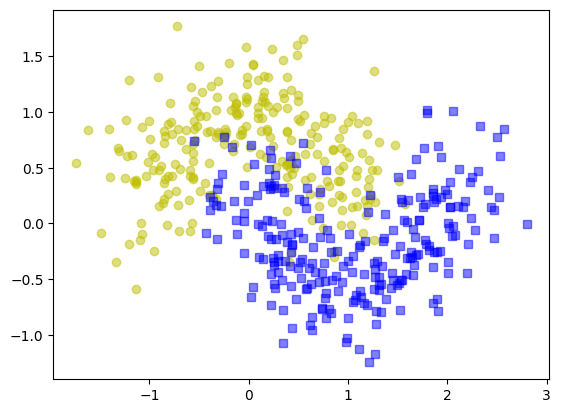

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=0.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=0.5)
plt.show()

###Hard voting
The simplest way to create an ensemble classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier. Set `voting="hard"` in `VotingClassifier`

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

If we look at each classifier’s accuracy on the test set, we see that the hard voting classifier slightly outperforms the individual classifiers.

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    cmat = confusion_matrix(y_test,y_pred)
    print(cmat)


LogisticRegression 0.864
[[56  5]
 [12 52]]
RandomForestClassifier 0.896
[[58  3]
 [10 54]]
SVC 0.896
[[60  1]
 [12 52]]
VotingClassifier 0.912
[[59  2]
 [ 9 55]]


###Soft voting
If all classifiers are able to estimate class probabilities (i.e., they all have a `predict_proba()` method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. It often achieves higher performance than hard voting.

Set `voting="soft"` in `VotingClassifier` and ensure that all classifiers can estimate class probabilities

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_sclf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_sclf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_sclf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    cmat = confusion_matrix(y_test,y_pred)
    print(cmat)


LogisticRegression 0.864
[[56  5]
 [12 52]]
RandomForestClassifier 0.896
[[58  3]
 [10 54]]
SVC 0.896
[[60  1]
 [12 52]]
VotingClassifier 0.92
[[59  2]
 [ 8 56]]


##Bagging
Bagging (bootstrap aggregating) is another approach to create ensembles using the same training algorithm for every predictor. The predictors are trained on different random subsets of the training set. Sampling is performed with replacement.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting
classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance.

In Scikit-learn you can use the `BaggingClassifier` class for bagging.
The following code trains an ensemble of 500 Decision Tree classifiers: each is trained on 100 training instances randomly sampled from the training set with replacement.

Note: The `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Tree classifiers.

Main parameters:

* `base_estimator`: The base estimator to fit on random subsets of the dataset.

* `n_estimators`: The number of base estimators in the ensemble.

* `max_samples`: The number of samples to draw from X to train each base estimator (with replacement by default)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
cmat = confusion_matrix(y_test,y_pred)
print(cmat)


0.904
[[57  4]
 [ 8 56]]


This is the result for a single decision tree classifier:

In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))
cmat = confusion_matrix(y_test,y_pred_tree)
print(cmat)

0.856
[[57  4]
 [14 50]]


This is the result for a random forest classifier with 500 estimators and default parameters.

What is the difference between a Random Forest Classifier and Bagging Decision trees?

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rnd = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rnd))
cmat = confusion_matrix(y_test,y_pred_rnd)
print(cmat)

0.888
[[58  3]
 [11 53]]


The following code generates and plots the decision boundary of a single Decision Tree, a bagging ensemble of 500 trees and a Random Forest with 500 trees, all trained on the moons dataset.

The ensembles’ predictions will likely generalize much better than the single Decision Tree’s predictions: the ensembles have a comparable bias but a smaller variance (they makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary2(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
#    plt.xlabel(r"$x_1$", fontsize=18)
#    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

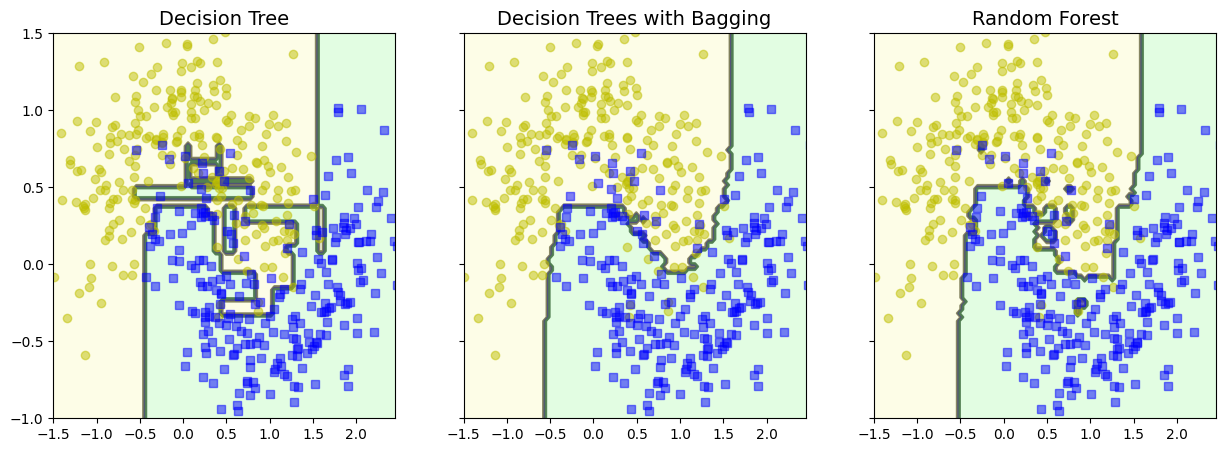

In [13]:
fix, axes = plt.subplots(ncols=3, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_decision_boundary2(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary2(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.sca(axes[2])
plot_decision_boundary2(rnd_clf, X, y)
plt.title("Random Forest", fontsize=14)
plt.ylabel("")
plt.show()

##Boosting
Boosting refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting
methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting.

##Adaboost

The principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data.

When training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

Once all predictors are trained, the ensemble makes predictions very much like bagging, except that predictors have different weights depending on their overall accuracy on the weighted training set.

The number of weak learners is controlled by the parameter `n_estimators`. The `learning_rate` parameter controls the contribution of the weak learners in the final combination.

By default, weak learners are decision stumps.
A decision stump is a Decision Tree with max_depth=1, in other words, a tree composed of a single decision node plus two leaf nodes.

Different weak learners can be specified through the `base_estimator` parameter. The main parameters to tune to obtain good results are `n_estimators` and the complexity of the base estimators (e.g., its depth `max_depth` or minimum required number of samples to consider a split `min_samples_split`).

The following code trains an AdaBoost classifier based on 200 decision stumps using Scikit-Learn’s `AdaBoostClassifier` class.


In [14]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ada))
cmat = confusion_matrix(y_test,y_pred_ada)
print(cmat)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.896
[[57  4]
 [ 9 55]]


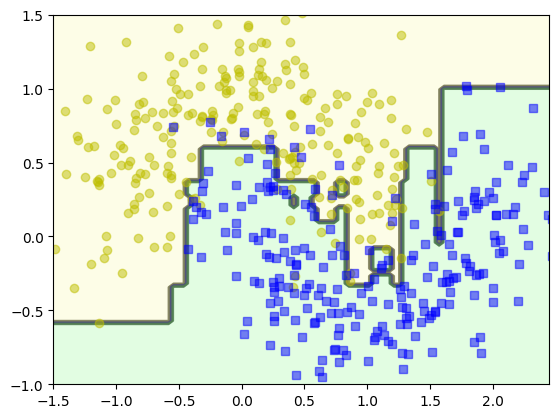

In [15]:
plot_decision_boundary2(ada_clf, X, y)

##Gradient boosting

Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting.

Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of modifying the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor. Weak learners are typically decision trees.

The number of weak learners is controlled by the parameter `n_estimators`; The size of each tree can be controlled either by setting the tree depth via `max_depth` or by setting the number of leaf nodes via `max_leaf_nodes`. The `learning_rate` is a hyper-parameter in the range (0.0, 1.0] that controls overfitting via shrinkage (a regularization technique that controls the contribution of each weak learner).

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbs_clf = GradientBoostingClassifier( n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
gbs_clf.fit(X_train, y_train)

y_pred_gbs = gbs_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_gbs))
cmat = confusion_matrix(y_test,y_pred_gbs)
print(cmat)

0.872
[[56  5]
 [11 53]]


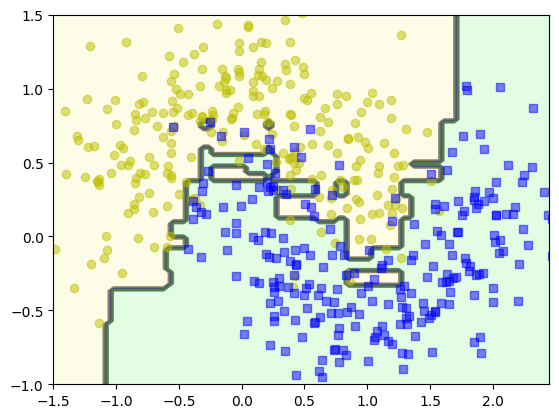

In [17]:
plot_decision_boundary2(gbs_clf, X, y)

##XGBoost
An optimized implementation of Gradient Boosting is available in
the Python library XGBoost, which stands for Extreme Gradient Boosting. Tt aims to be extremely fast, scalable, and portable.

You can learn more here:

https://xgboost.readthedocs.io/en/stable/

##PART2: MNIST using ensembles
1. Load the MNIST dataset (check Lab6)

2. Split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation -selected from the original train set with 60.000 images-, and 10,000 for testing). Use smaller sets if you have time issues with colab.

3. Train various classifiers, such as a Random Forest classifier, an SVM classifier, a Neural Network and/or other models. Compute performance metrics and confusion matrices for all the classifiers.

Note: You can define a list of classifiers, and then train each classifier and see the performance of each one using

```
estimators = [clf_1, clf_2, clf_3, clf_4]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

[estimator.score(X_val, y_val) for estimator in estimators]
```



3. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting. You can add or remove estimators from the list.

4. Once you have found one ensemble, try it on the test set. How much better does it perform compared to the individual classifiers?

In [18]:
# your code here




##Optional task: MNIST using XGBoost


In [19]:
# your code here

